# **Engineering Target Variables**

The mental health survey data, distinct from the EMA data that's collected over the course of the study, is split into seven dataframes taking up particular indictors, and each of those dataframes contains information from a survey at the beginning of the semester, and a survey at the end.

In the cleaning and transformation process, I'll need to aggregate the answers to the questions in each survey into one core feature per indicator, but and then split this feature into it's pre-semester and post-semester components, and also derive a third feature which is the difference between the two. I will use the pre-semester survey if the feature is used as an exogenous variable, and the post-semester survey (or difference feature) if it's the target variable. All of these features will need to be combined into one student-wise dataframe, so I'll need to check whether there are discreptancies in terms of what students are covered.

I will also bring in the data from the grades section of the data in order to assess academic performance. There are only 30 students in the grades dataframe, of which only 25 also have mental health data. Due to this restriction, I will retain three separate dataframes by the end of the process, to make sure that the maximum number of observations can be involved in any given model.

In [1]:
from zipfile import ZipFile
import io
import os
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statistics as stats

# 1. Cleaning Data and Engineering Mental Health Aggregate Features

In [17]:
# Loading csvs into pandas dfs

path = '/Users/kristiancanler/Documents/Data/dartmouth_dataset/dataset/survey/LonelinessScale.csv'
loneliness = pd.read_csv(path)

path = '/Users/kristiancanler/Documents/Data/dartmouth_dataset/dataset/survey/PerceivedStressScale.csv'
stress = pd.read_csv(path)

path = '/Users/kristiancanler/Documents/Data/dartmouth_dataset/dataset/survey/PHQ-9.csv'
depression = pd.read_csv(path)

# More info on flourishing scale: https://ggsc.berkeley.edu/images/uploads/The_Flourishing_Scale.pdf
path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/survey/FlourishingScale.csv'
flourishing = pd.read_csv(path)

# More info on panas scale: https://ogg.osu.edu/media/documents/MB%20Stream/PANAS.pdf
path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/survey/panas.csv'
panas = pd.read_csv(path)

Before moving on I'd like to know which values are missing from each dataframe.

In [54]:
# Using for loop to for uid column and to create list
# of all unique values in each df
id_list = []
for df in [loneliness, stress, depression, flourishing, panas]:
    
    # Taking opportunity in for loop to lower strings in all dfs
    try:
        for col in df.iloc[:, 2:]:
            df[col] = df[col].str.lower()
    except:
        pass
    
    # Stripping of 'u' of id and setting as integer
    try:
        df.uid = df.uid.str.extract('(\d\d)').astype(int)
    except:
        pass
    
    # Appending unique values to id_list
    id_list = id_list + list(df.uid.unique())

# Getting unique values for all values in all dfs
id_list = pd.Series(id_list).unique()

# Creating function to return ids that are not in a df
def not_in(df):
    return [i for i in id_list if i not in list(df.uid.unique())]

# Creating dictionary with dfs and absent ids
not_in = {
    'loneliness': not_in(loneliness),
    'stress': not_in(stress),
    'depression': not_in(depression),
    'flourishing': not_in(flourishing),
    'panas': not_in(panas)
}
not_in

{'loneliness': [54],
 'stress': [39],
 'depression': [54],
 'flourishing': [54],
 'panas': []}

Luckily there's not more than one missing id in any given dataframe, which can be easily handled with mean imputation most likely.

In additon to cleaning values and giving them ordinal codes, below I'm dealing with those questions that have a reverse scale from the others, where a higher score indicates *less* depression. (I'll be repeating this process for most of the dataframes.)

## 1.1 Loneliness

In [40]:
# Printing unique values for survey questions
pd.unique(loneliness.iloc[:, 2:].values.ravel('K'))

array(['sometimes', 'rarely', 'often', 'never'], dtype=object)

In [44]:
# Translating string responses to ordinal codes
loneliness.replace('never', 0, inplace=True)
loneliness.replace('rarely', 1, inplace=True)
loneliness.replace('sometimes', 2, inplace=True)
loneliness.replace('often', 4, inplace=True)

# Naming values to be flipped and pairing with reversed questions
flip_vars = {'1. I feel in tune with the people around me':
                 '1. I do not feel in tune with the people around me',
             '4. I do not feel alone':
                 '4. I feel alone',
             '5. I feel part of a group of friends':
                 '5. I do not feel part of a group of friends',
             '6. I have a lot in common with the people around me':
                 '6. I do not have a lot in common with the people around me',
             '9. I am an outgoing person':
                 '9. I am not an outgoing person',
             '10. There are people I feel close to':
                 '10. There are not any people I feel close to',
             '15. I can find companionship when I want it':
                 '15. I cannot find companionship when I want it',
             '16. There are people who really understand me':
                 '16. There are not people who really understand me',
             '19. There are people I can talk to':
                 '19. There are not any people I can talk to',
             '20. There are people I can turn to':
                 '20. There are not any people I can turn to'}

# Instead of creating a codebook in a separate document
# I'll build it out as a growing dictionary here, which
# will be exportable as a JSON.
codebook = {
    'loneliness_avg': {0: 'never',
                   1: 'rarely',
                   2: 'sometimes',
                   3: 'often',
                   4: 'always'}
}

# Flipping values
for var in flip_vars.keys():
    # Never to Always
    loneliness.loc[loneliness[var]==0, var] = 4
    # Rarely to Often
    loneliness.loc[loneliness[var]==1, var] = 3
    # Sometimes stays Sometimes
    # Often to Rarely
    loneliness.loc[loneliness[var]==3, var] = 1

In [33]:
loneliness.columns

Index(['uid', 'type', '1. I feel in tune with the people around me',
       '2. I lack companionship', '3. There is no one I can turn to',
       '4. I do not feel alone', '5. I feel part of a group of friends',
       '6. I have a lot in common with the people around me',
       '7. I am no longer close to anyone',
       '8. My interests and ideas are not shared by those around me',
       '9. I am an outgoing person', '10. There are people I feel close to',
       '11. I feel left out', '12. My social relationships are superficial',
       '13. No one really knows me well', '14. I feel isolated from others',
       '15. I can find companionship when I want it',
       '16. There are people who really understand me',
       '17. I am unhappy being so withdrawn',
       '18. People are around me but not with me',
       '19. There are people I can talk to',
       '20. There are people I can turn to'],
      dtype='object')

In [45]:
# Creating feature which is average or sum of all answers
loneliness['loneliness_avg'] = loneliness.iloc[:, 2:].mean(axis=1)
loneliness['loneliness_sum'] = loneliness.iloc[:, 2:].sum(axis=1)

# Multiplying keys by the number of questions to
# correspond to markers for sum to be interpretable
codebook['loneliness_sum'] =  {
    0: 'never',
    20: 'rarely',
    40: 'sometimes',
    60: 'often',
    80: 'always'
}

## 1.2 Perceived Stress

In [55]:
# Printing unique values for survey questions
pd.unique(stress.iloc[:, 2:].values.ravel('K'))

array(['sometime', 'fairly often', 'almost never', 'very often', 'never',
       nan], dtype=object)

In [56]:
# Adding entry to codebook
codebook['stress'] = {
    0: 'never',
    1: 'almost never',  # For loneliness 4 is 'rarely', for stress
                        # it's 'almost never'
    2: 'sometime',
    3: 'fairly often',  # For loneliness 3 is 'often', for stress
                        # it's 'fairly often'
    4: 'very often'     # For loneliness 4 is 'always', for stress
                        # it's 'very often'
}

# Translating string responses to ordinal codes
stress.replace('never', 0, inplace=True)
stress.replace('almost never', 1, inplace=True)
stress.replace('sometime', 2, inplace=True)
stress.replace('fairly often', 3, inplace=True)
stress.replace('very often', 4, inplace=True)

# Creating renamed question names for flipping
flip_vars = {'4. In the last month, how often have you felt confident about your ability to handle your personal problems?':
                 '4. In the last month, how often have you not felt confident about your ability to handle your personal problems?',
             '5. In the last month, how often have you felt that things were going your way?':
                 '5. In the last month, how often have you felt that things were not going your way?',
             '7. In the last month, how often have you been able to control irritations in your life?':
                 '7. In the last month, how often have you not been able to control irritations in your life?',
             '8. In the last month, how often have you felt that you were on top of things?':
                 '8. In the last month, how often have you felt that you were not on top of things?'
            }

# Renaming flipped features. This needs to happen before flipping the values
stress.rename(flip_vars, axis=1, inplace=True)

# Flipping values for flip features
for var in list(flip_vars.values()):
    stress.loc[stress[var]==0, var] = 4
    stress.loc[stress[var]==1, var] = 3
    stress.loc[stress[var]==3, var] = 1
    stress.loc[stress[var]==4, var] = 0

In [58]:
# Creating feature which is average or sum of all answers
stress['stress_avg'] = stress.iloc[:, 2:].mean(axis=1)
stress['stress_sum'] = stress.iloc[:, 2:].sum(axis=1)

# Multiplying keys by the number of questions to
# correspond to markers for sum to be interpretable
codebook['stress_sum'] =  {
    0: 'never',
    10: 'almost never',
    20: 'sometime',
    30: 'fairly often',
    40: 'very often'
}

## 1.3 Depression (PHQ-9)

In [61]:
# Printing unique values for survey questions
pd.unique(depression.iloc[:, 2:].values.ravel('K'))

array(['not at all', 'several days', 'more than half the days',
       'nearly every day', 'not difficult at all', 'very difficult',
       'somewhat difficult', nan, 'extremely difficult'], dtype=object)

In [68]:
# Adding entry to codebook
codebook['depression_avg'] = {
    0: 'not at all / not difficult at all',
    # I'm not including a '1' category because there's no
    # 'rare'/'infrequently' equivalent for PHQ-9
    2: 'several days / somewhat difficult',
    3: 'more than half the days / very difficult',
    4: 'nearly every day / extremely difficult'
}

# Creating numeric equivalents for ordinal variables
depression.replace('not at all',  0, inplace=True)
depression.replace('several days',  2, inplace=True)
depression.replace('more than half the days',  3, inplace=True)
depression.replace('nearly every day',  4, inplace=True)
depression.replace('not difficult at all',  0, inplace=True)
depression.replace('somewhat difficult',  2, inplace=True)
depression.replace('very difficult',  3, inplace=True)
depression.replace('extremely difficult',  4, inplace=True)


# This question is so long it makes the visualization hard to format. I'll just add
# a (+) as a reminder the original question is longer
depression.rename({'Moving or speaking so slowly that other people could have noticed. Or the opposite being so figety or restless that you have been moving around a lot more than usual':
                   'Moving or speaking so slowly that other people could have noticed. (+)'},
             axis=1,
             inplace=True)

try:
    # Dropping 'response' columns
    depression.drop(columns=['Response'], inplace=True)
except:
    pass

In [95]:
# Creating mean and sum features
depression['depression_avg'] = depression.iloc[:, 2:].mean(axis=1)
depression['depression_sum'] = depression.iloc[:, 2:].sum(axis=1)

# Multiplying keys by the number of questions (8) to
# correspond to markers for sum to be interpretable
codebook['depression_sum'] = {
    0: 'not at all / not difficult at all',
    16: 'several days / somewhat difficult',
    24: 'more than half the days / very difficult',
    32: 'nearly every day / extremely difficult'
}

## 1.4 Flourishing

In [71]:
# Future reminder that there are no word-labels for 1–7 scale
codebook['flourishing'] = 'unlabelled scale of 1–7'

# Creating mean and sum features
flourishing['flourishing_avg'] = flourishing.iloc[:, 2:].mean(axis=1)
flourishing['flourishing_sum'] = flourishing.iloc[:, 2:].sum(axis=1)

## 1.5 Positive and Negative Affect

In [79]:
# Lowering column names
panas.columns = panas.columns.str.lower()
panas.columns

Index(['uid', 'type', 'interested', 'distressed', 'upset', 'strong', 'guilty',
       'scared', 'hostile ', 'enthusiastic', 'proud', 'irritable', 'alert',
       'inspired', 'nervous', 'determined ', 'attentive', 'jittery', 'active ',
       'afraid '],
      dtype='object')

In [80]:
# Creating mean and sum features for positive and negative affect
pos_affect = ['interested', 'strong', 'enthusiastic', 'proud', 'alert', 'inspired',
              'determined', 'attentive', 'active']
panas['panas_pos_avg'] = panas.loc[:, pos_affect].mean(axis=1)
panas['panas_pos_sum'] = panas.loc[:, pos_affect].sum(axis=1)

neg_affect = ['distressed', 'upset', 'guilty', 'scared', 'hostile',
              'irritable', 'nervous', 'jittery', 'afraid']
panas['panas_neg_avg'] = panas.loc[:, neg_affect].mean(axis=1)
panas['panas_neg_sum'] = panas.loc[:, neg_affect].sum(axis=1)

# Creating net features
panas['panas_net_avg'] = panas.panas_pos_avg - panas.panas_neg_avg
panas['panas_net_sum'] = panas.panas_pos_sum - panas.panas_neg_sum

# Codebook entry
codebook['panas'] = 'unlabeled 1–5 scale'

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# 2. Generating Student-wise Dataframe

For the sake of simplicity, I'll be selective about what features to include in the final dataframes, `pre_survey`, `post_survey`, and `delta_survey`: just the sum features, and just the net feature for panas. So I should end up with a dataframe with six columns and just a few missing values (do to the ids that aren't shared).

In [105]:
pre_survey = pd.DataFrame()
pre_survey['uid'] = id_list

# Merging 'pre_survey' with other dfs limited to id col and
# target col, filtered by type ('pre'/'post'), using a function
# in a for loop iterating over a dictionary of dfs and target vars

def merge_survey(merged_df, time, df, target):
    return merged_df.merge(
        df.loc[df.type==time,
               ['uid', target]],
        on='uid',
        how='outer'
    )

merging_dfs = {
    'loneliness_sum': loneliness,
    'stress_sum': stress,
    'depression_sum': depression,
    'flourishing_sum': flourishing,
    'panas_net_sum': panas
}

for key in merging_dfs:
    pre_survey = merge_survey(pre_survey, 'pre',
                              merging_dfs[key], key)
    
pre_survey.head()

,uid,loneliness_sum,stress_sum,depression_sum,flourishing_sum,panas_net_sum
0,0,44.10,26.4,4.444444,49.142857,6.0
1,1,43.05,16.5,11.111111,50.625000,5.0
2,2,44.10,18.7,23.333333,51.750000,6.0
3,3,36.75,9.9,4.444444,38.250000,2.0
4,4,32.55,20.9,13.333333,30.375000,8.0


In [106]:
post_survey = pd.DataFrame()
post_survey['uid'] = id_list

for key in merging_dfs:
    post_survey = merge_survey(post_survey, 'post',
                               merging_dfs[key], key)
post_survey.head()

,uid,loneliness_sum,stress_sum,depression_sum,flourishing_sum,panas_net_sum
0,0,37.80,16.5,6.666667,50.625,3.0
1,1,48.30,17.6,8.888889,51.750,6.0
2,2,42.00,27.5,10.000000,49.500,13.0
3,3,36.75,19.8,8.888889,34.875,5.0
4,4,39.90,18.7,16.666667,37.125,10.0


Now that I've created separate dataframes for the pre-semester survey and the post-semester survey, I can create a third dataframe, `delta_survey`, with the change between the two.

In [109]:
# Adding dfs with id indexed out
delta_survey = pre_survey.iloc[:, 1:].subtract(post_survey.iloc[:, 1:], fill_value=0)

# Adding id back in an returning it to beginning of df
delta_survey['uid'] = id_list
delta_survey = delta_survey[
    delta_survey.columns.to_list()[-1:] +
    delta_survey.columns.to_list()[:-1]
]
delta_survey.head()

,uid,loneliness_sum,stress_sum,depression_sum,flourishing_sum,panas_net_sum
0,0,6.30,9.9,-2.222222,-1.482143,3.0
1,1,-5.25,-1.1,2.222222,-1.125000,-1.0
2,2,2.10,-8.8,13.333333,2.250000,-7.0
3,3,0.00,-9.9,-4.444444,3.375000,-3.0
4,4,-7.35,2.2,-3.333333,-6.750000,-2.0


## 2.1 Visualizing Features

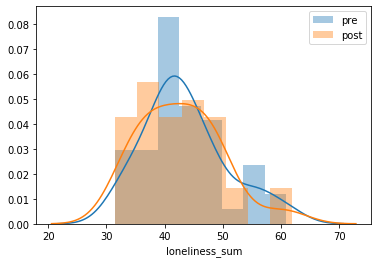

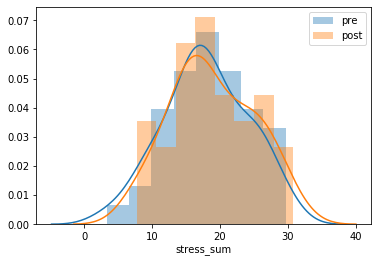

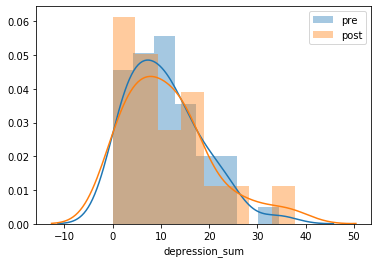

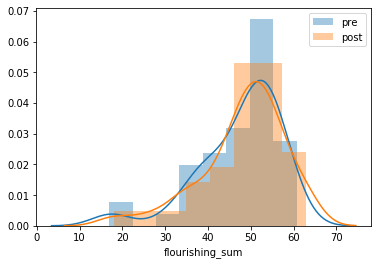

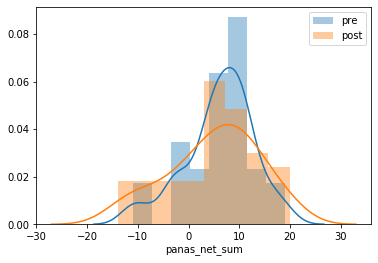

In [123]:
# Visualizing distributions
for var in ['loneliness_sum', 'stress_sum', 'depression_sum',
       'flourishing_sum', 'panas_net_sum']:
    sns.distplot(pre_survey[var].dropna(),
                 label='pre',
                 bins=8)
    sns.distplot(post_survey[var].dropna(),
                 label='post',
                 bins=8)
    plt.legend()
    plt.show()

We see less kurtosis across the board in `post_survey`: the time of the semester across the board seems to have the effect of spreading out the students perceptions.

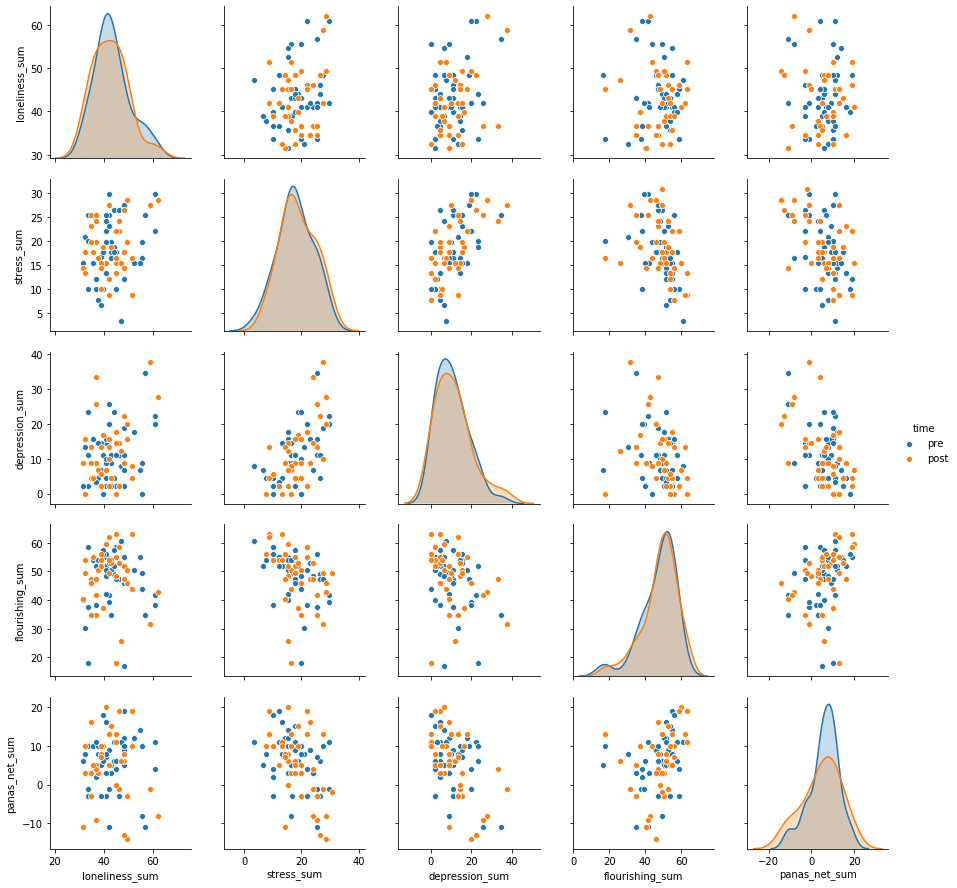

,loneliness_sum,stress_sum,depression_sum,flourishing_sum,panas_net_sum
loneliness_sum,1.000000,0.237997,0.289937,-0.044167,-0.039901
stress_sum,0.237997,1.000000,0.595245,-0.404198,-0.430081
depression_sum,0.289937,0.595245,1.000000,-0.329134,-0.469172
flourishing_sum,-0.044167,-0.404198,-0.329134,1.000000,0.309958
panas_net_sum,-0.039901,-0.430081,-0.469172,0.309958,1.000000


In [129]:
pre_survey['time'] = 'pre'
post_survey['time'] = 'post'
survey = pd.concat([pre_survey, post_survey],
                   axis=0)
sns.pairplot(data=survey[['loneliness_sum', 'stress_sum', 'depression_sum',
       'flourishing_sum', 'panas_net_sum', 'time']],
             hue='time')
plt.show()

survey[['loneliness_sum', 'stress_sum', 'depression_sum',
       'flourishing_sum', 'panas_net_sum']].corr()

Notable correlations:
* Strongest correlation (60%) is between depression and stress
* Strong negative correlation (-47%) between positive affect and depression
* Strong negative correlation (-43%) between positive affect and stress

Noteable weak correlations:
* Almost no correlation between loneliness and flourishing/positive affect
* Weak correlation (24–29%) between loneliness and stress/depression
* Weak correlation (31%) between flourishing and positive affect

# 2. Setting up Academic Performance Data

In [138]:
path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/education/grades.csv'
grades = pd.read_csv(path)

grades.columns = ['uid', 'gpa_all', 'gpa_13s', 'cs']
grades = grades[['uid', 'gpa_all', 'gpa_13s']]
try:
    grades.uid = grades.uid.str.extract('(\d\d)').astype(int)
except:
    pass

In [142]:
# Creating combined dataframes with limited observations
pre_survey_w_grades = grades.merge(pre_survey, on='uid', how='inner')
post_survey_w_grades = grades.merge(post_survey, on='uid', how='inner')
delta_survey_w_grades = grades.merge(delta_survey, on='uid', how='inner')
print('Studnets in grades:', len(grades))
print('Students in pre_survey:', len(pre_survey))
print('Students in post_survey:', len(post_survey))
print('Students in ∆_survey:', len(delta_survey))
print('Students in pre/grades:', len(pre_survey_w_grades))
print('Students in post/grades: ', len(pre_survey_w_grades))
print('Students in ∆/grades: ', len(pre_survey_w_grades))

Studnets in grades: 30
Students in pre_survey: 47
Students in post_survey: 47
Students in ∆_survey: 47
Students in pre/grades: 28
Students in post/grades:  28
Students in ∆/grades:  28


Looks like I was mistaken, and there are in fact just two students in the grades dataframe who we don't have mental health data for. This is good news, since we will only lose two observations if we want to use `pre_survey` as independent variables in a model predicting GPA.

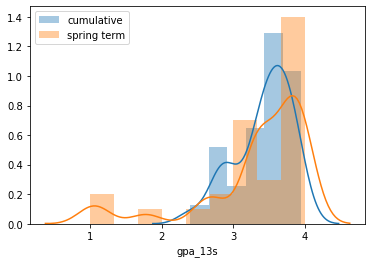

In [157]:
sns.distplot(grades.gpa_all,
             label='cumulative')
sns.distplot(grades.gpa_13s,
             label='spring term')
plt.legend()
plt.show()

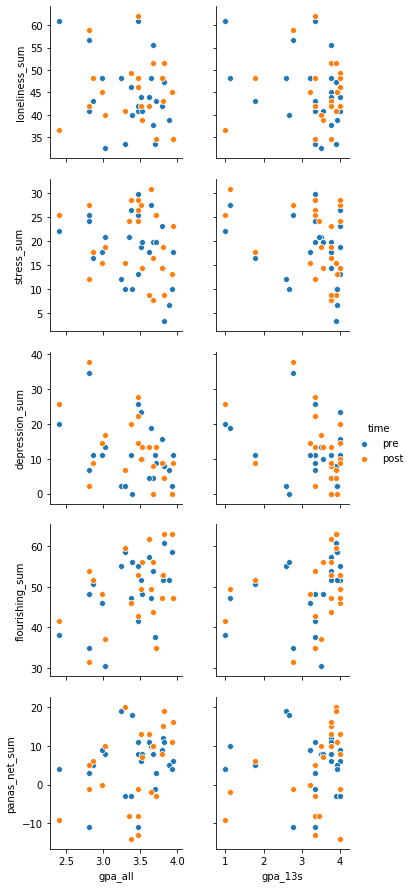

In [162]:
survey_w_grades = grades.merge(survey, on='uid', how='inner')

sns.pairplot(
    data=survey_w_grades,
    x_vars=['gpa_all', 'gpa_13s'],
    y_vars=['loneliness_sum', 'stress_sum',
       'depression_sum', 'flourishing_sum', 'panas_net_sum'],
    hue='time'
)
splt.show()

In [172]:
health_vars = ['loneliness_sum', 'stress_sum',
       'depression_sum', 'flourishing_sum', 'panas_net_sum']

print('Pre / gpa_all')
print(pre_survey_w_grades[health_vars].corrwith(pre_survey_w_grades.gpa_all))
print('\n', 'Pre / gpa_13s')
print(pre_survey_w_grades[health_vars].corrwith(pre_survey_w_grades.gpa_13s))
print('\n', 'Post / gpa_all')
print(post_survey_w_grades[health_vars].corrwith(pre_survey_w_grades.gpa_all))
print('\n', 'Post / gpa_13s')
print(post_survey_w_grades[health_vars].corrwith(pre_survey_w_grades.gpa_13s))
print('\n', '∆ / gpa_all')
print(delta_survey_w_grades[health_vars].corrwith(pre_survey_w_grades.gpa_all))
print('\n', '∆ / gpa_13s')
print(delta_survey_w_grades[health_vars].corrwith(pre_survey_w_grades.gpa_13s))

Pre / gpa_all
loneliness_sum    -0.254628
stress_sum        -0.308353
depression_sum    -0.322355
flourishing_sum    0.378071
panas_net_sum      0.215814
dtype: float64

 Pre / gpa_13s
loneliness_sum    -0.379292
stress_sum        -0.290866
depression_sum    -0.271609
flourishing_sum    0.293624
panas_net_sum     -0.062688
dtype: float64

 Post / gpa_all
loneliness_sum    -0.028093
stress_sum        -0.176822
depression_sum    -0.492494
flourishing_sum    0.382533
panas_net_sum      0.386022
dtype: float64

 Post / gpa_13s
loneliness_sum     0.048209
stress_sum        -0.367500
depression_sum    -0.433506
flourishing_sum    0.305247
panas_net_sum      0.395142
dtype: float64

 ∆ / gpa_all
loneliness_sum     0.123238
stress_sum        -0.015176
depression_sum     0.311789
flourishing_sum    0.127615
panas_net_sum     -0.171568
dtype: float64

 ∆ / gpa_13s
loneliness_sum    -0.439797
stress_sum        -0.047015
depression_sum    -0.156803
flourishing_sum   -0.077168
panas_net_sum     -0.

Surprising / interesting correlations:
* There are often signficant differences across the board between the correlations between mental health metrics and cumulative GPA on the one hand and spring term GPA on the other
* Pre-term loneliness correlates significantly with term GPA, but loneliness from the post-term loneliness doesn't at all.
* Post-term stress also correlates less than pre-term stress, but post-term depression correlates signficantly more than pre-term depression.
* Pre-term positive affect doesn't correlate with term GPA, but post-term positive affect strongly correlates.
* Deltas don't correlate with cumulative gpa, with the exception of depression, which cumulates *postively* (31%).
* Stress, depression, and flourishing deltas don't correlate much (depression) or at all (stress, flourishing) with term GPA, but there's a significant (-42–44%) negative correlation with loneliness & positive affect with term GPA.

In [177]:
# Downloading dataframe as CSV

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/grades_final.csv'
grades.to_csv(path, index=False)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/pre_survey_final.csv'
pre_survey.to_csv(path, index=False)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/post_survey_final.csv'
post_survey.to_csv(path, index=False)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/delta_survey_final.csv'
delta_survey.to_csv(path, index=False)
